# Quick Start with Clarifai

![Clarifai logo](https://www.clarifai.com/hs-fs/hubfs/logo/Clarifai/clarifai-740x150.png?width=240)

This is a self-contained notebook that shows how to run Clarifai models with your account credentials and start getting insights from your images.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Clarifai/colab-notebooks/blob/main/Quick_Start_on_Clarifai_Image_Predictions.ipynb)

## Get Started 

*  Install Clarifai gRPC client for Python

In [ ]:
!pip install clarifai-grpc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


*   Install other dependencies



In [ ]:
import os
from io import BytesIO
import skimage 
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

%matplotlib inline

## Initialize the Clarifai gRPC-based client
Let's import the gRPC-based objects needed to communicate with the Clarifai platform.

In [ ]:
from clarifai_grpc.channel.clarifai_channel import ClarifaiChannel
from clarifai_grpc.grpc.api import resources_pb2, service_pb2, service_pb2_grpc
from clarifai_grpc.grpc.api.status import status_pb2, status_code_pb2

# Construct the communications channel 
channel = ClarifaiChannel.get_grpc_channel()
# Construct the V2Stub object for accessing all the Clarifai API functionality
stub = service_pb2_grpc.V2Stub(channel)


## Set up Authorization

Set up the metadata object that's used to authenticate your access to the Clarifai platform. 

You can follow [this page](https://docs.clarifai.com/clarifai-basics/authentication/authorize/) to learn how to provide your user ID, API key, and app ID.

In [ ]:
USER_ID = 'YOUR_USER_ID_HERE'
PAT = 'YOUR_PAT_HERE'
APP_ID = 'YOUR_APP_ID_HERE'

metadata = (('authorization', 'Key ' + PAT),)
userDataObject = resources_pb2.UserAppIDSet(user_id=USER_ID, app_id=APP_ID)

## Collect Your Inputs

Let's grab the images we'll use for making the predictions. 

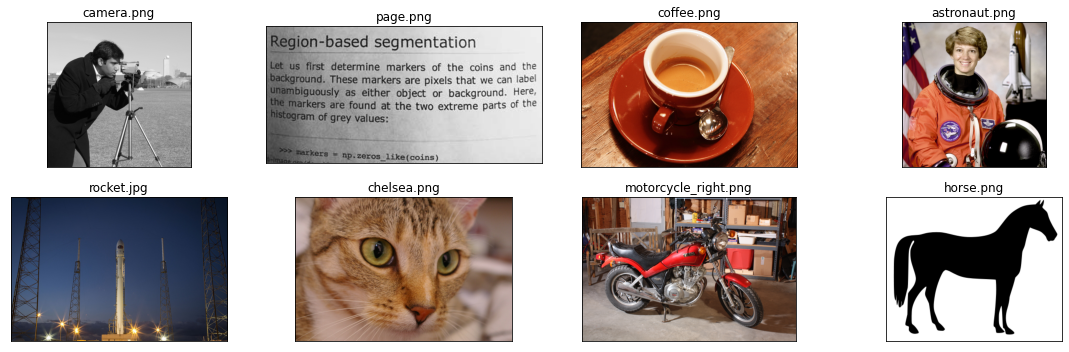

In [ ]:
# images in skimage to use
descriptions = [
    "page",
    "chelsea",
    "astronaut",
    "rocket",
    "motorcycle_right",
    "camera",
    "horse", 
    "coffee"
]

original_images = []
images = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")
  
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(image)

plt.tight_layout()

## Prepare Your Inputs


Let's convert the images into Input objects for batch prediction. 

In [ ]:
inputs = []
for image in images:
  buffered = BytesIO()
  image.save(buffered, format="PNG")
  inputs.append(
      resources_pb2.Input(
          data=resources_pb2.Data(
              image=resources_pb2.Image(
                  base64=buffered.getvalue()
              )
          )
      )
  )

## Make Predictions
The Clarifai's  [General Model](https://clarifai.com/clarifai/main/models/general-image-recognition) is a visual classifier for identifying a variety of concepts, common objects, etc. It is a great all-purpose solution for most visual recognition needs with industry-leading performance. It works on both images and videos. 


In [ ]:
MODEL_ID = 'general-image-recognition'

In [ ]:
post_model_outputs_response = stub.PostModelOutputs(
    service_pb2.PostModelOutputsRequest(
        user_app_id=userDataObject,  # The userDataObject is created in the overview and is required when using a PAT
        model_id=MODEL_ID,
        inputs=inputs
    ),
    metadata=metadata
)
if post_model_outputs_response.status.code != status_code_pb2.SUCCESS:
    print(post_model_outputs_response.status)
    raise Exception("Post model outputs failed, status: " + post_model_outputs_response.status.description)

## Generate Visual Diagrams
Let's plot diagrams that showcase the identified concepts against the propability of their occurence in the images.

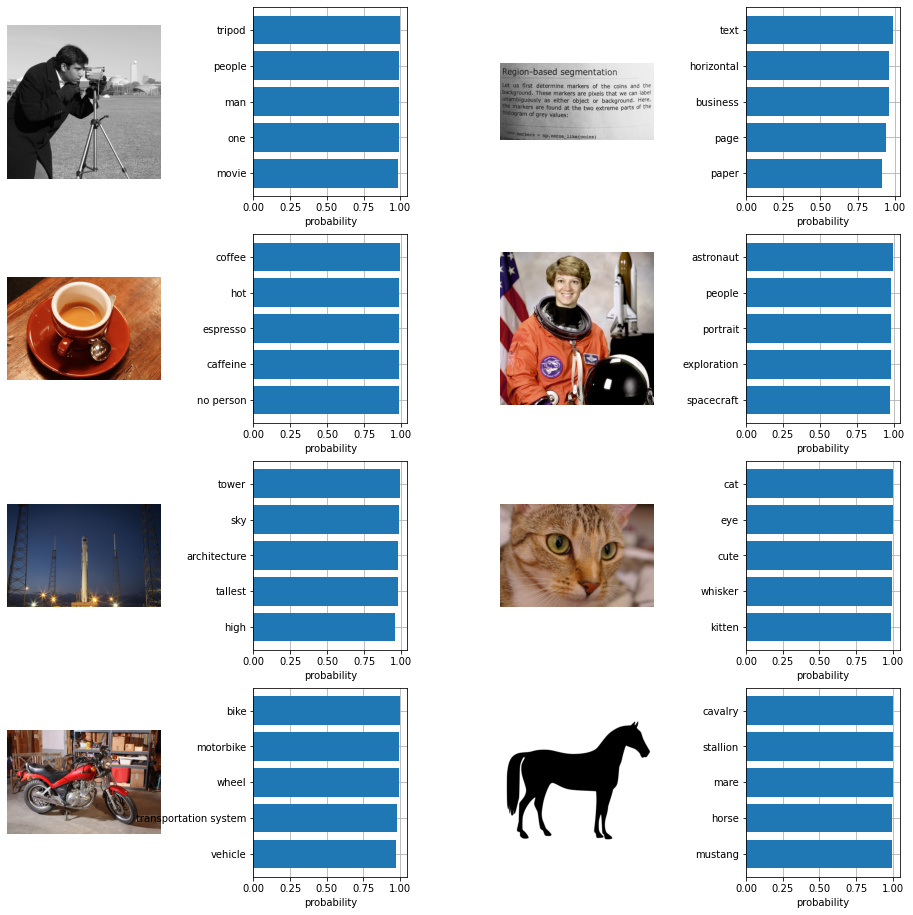

In [ ]:
plt.figure(figsize=(16, 16))

for i, (image, output) in enumerate(zip(original_images, post_model_outputs_response.outputs)):
    top_preds = {
      concept.name: concept.value for concept in output.data.concepts[:5]
    }
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(len(top_preds))
    plt.grid()
    plt.barh(y, list(top_preds.values()))
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, list(top_preds.keys()))
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.6)
plt.show()